In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import mglearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import random

In [3]:
models={}

In [4]:
data=pd.read_csv('data2.csv')
data=data.drop(columns=['file_name','Unnamed: 0'])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['virus'],test_size=0.25, random_state=42)
X_train,X_test,=X_train.astype(str),X_test.astype(str)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
model=LogisticRegression(solver='newton-cg',C=0.5)

In [7]:
text_train=X_train.copy()
text_test=X_test.copy()

In [8]:
vect_for_bag = CountVectorizer(min_df=10).fit(text_train)
X_train = vect_for_bag.transform(text_train)
print("X_train с min_df: {}".format(repr(X_train)))

X_train с min_df: <5562x5829 sparse matrix of type '<class 'numpy.int64'>'
	with 435490 stored elements in Compressed Sparse Row format>


In [9]:
feature_names = vect_for_bag.get_feature_names()
print("Первые 50 признаков:\n{}".format(feature_names[:50]))
print("Каждый 700-й признак:\n{}".format(feature_names[::700]))

Первые 50 признаков:
['00', '000', '0000', '000000', '000000000000001', '000000000046', '0000001', '000001', '00001', '0001', '00020819', '00020820', '00020906', '0002e157', '0006', '001', '0018', '002', '003', '004', '005', '006', '007', '008', '0085', '009', '00_', '00a0c9054228', '01', '010', '011', '012', '013', '014', '015', '016', '017', '018', '02', '03', '04', '05', '06', '07', '08', '08002b3371b5', '09', '0_', '0b', '0e']
Каждый 700-й признак:
['00', '520', 'both', 'displayalerts', 'hex', 'microsofthobby', 'ramblings', 'ta', 'xlautomatic']


In [10]:
model.fit(X_train,y_train)
print("Правильность на учебном наборе: {:.2f}".format(model.score(X_train, y_train)))

Правильность на учебном наборе: 1.00


In [11]:
models.update({"LogisticRegression(solver='newton-cg',C=0.5)":[model,vect_for_bag]})

In [12]:
X_test=vect_for_bag.transform(text_test)
print("Правильность на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))

Правильность на тестовом наборе: 0.98


In [13]:
from sklearn.metrics import roc_auc_score
print("Правильность на тестовом наборе: {:.2f}".format(roc_auc_score(y_test,model.predict(X_test))))


Правильность на тестовом наборе: 0.98


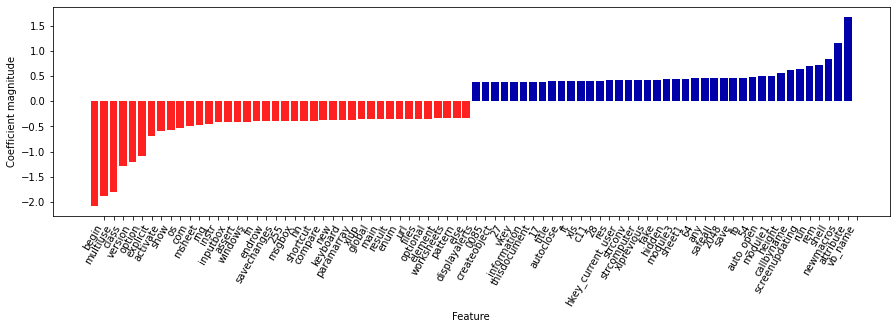

In [14]:
mglearn.tools.visualize_coefficients(
model.coef_,
feature_names, n_top_features=40)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [16]:
vect=TfidfVectorizer(min_df=20).fit(text_train)
X_train = vect.transform(text_train)


max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# получаем имена признаков
feature_names = np.array(vect.get_feature_names())
print("Признаки с наименьшими значениями tfidf:\n{}".format(
feature_names[sorted_by_tfidf[:30]]))
print("Признаки с наибольшими значениями tfidf: \n{}".format(
feature_names[sorted_by_tfidf[-30:]]))
X_test=vect.transform(text_test)

Признаки с наименьшими значениями tfidf:
['compressiontype' 'compressionmemory' 'temp_data' '_search' 'setforth'
 'parth' 'minimizeall' 'confidential_file' 'header_end'
 'cabinetnametemplate' 'deleteaftersubmit' 't_asc' 'disk1' '_clear'
 'trimed_data' '请用' '解锁此文件' 'lzx' 'inf' 'objnamespace' 'email_address'
 'creatcab_sendmail' 'actionjudge' 'restorebeforesend' 'todole'
 'cc_email_add' 'frag2' 'objmessage' 'targetfolder' 'massive_sendmail']
Признаки с наибольшими значениями tfidf: 
['ucase' 'sub' 'msheet' 'bytes' 'activechart' 'function' 'fb' 'record'
 'litstr' 'param_vector' 'litdi2' 'array' 'cells' 'add' 'mid' 'backcolor'
 'chr' 'writeline' 'folderpath' 'case' 'temp_matrix' '54' 'args' 'chrw'
 'null' 'additem' 'cbool' 'str' 'range' 'cdbl']


In [17]:
model_tdf=LogisticRegression(solver='newton-cg',C=0.5)


In [18]:
model_tdf.fit(X_train,y_train)
print("Правильность на учебном наборе: {:.2f}".format(model_tdf.score(X_train, y_train)))

Правильность на учебном наборе: 0.96


In [19]:
models.update({"LogisticRegression(solver='newton-cg',C=0.5) with TFIDF":[model_tdf,vect]})

In [20]:
print("Правильность на тестовом наборе: {:.2f}".format(model_tdf.score(X_test, y_test)))

Правильность на тестовом наборе: 0.95


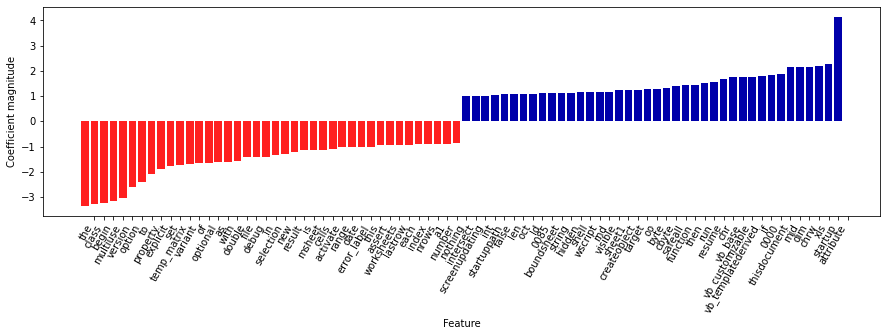

In [21]:
mglearn.tools.visualize_coefficients(
model_tdf.coef_,
feature_names, n_top_features=40)

In [22]:
def test_for_mal():
    path_malicios = r'/home/v-osipov/PycharmProjects/vba/data/malicious/'
    
    files_malicious = list(map(lambda x: path_malicios + x, 
                               random.sample(os.listdir(path_malicios),
                                             random.randint(0, 500))))
    temp_data = pd.DataFrame()

    for m in files_malicious:
        try:
            with open(m) as f:
                temp_data = temp_data.append({'text': f.read(), 'virus': 1}, ignore_index=True)
        except UnicodeDecodeError:
            pass

    return temp_data



In [23]:
test_mal=test_for_mal()

In [24]:
test_malvare_scrpt,answer=test_mal['text'].astype(str),test_mal['virus']

In [25]:
test_malvare_scrpt.describe()

count                                                   494
unique                                                  358
top       Attribute VB_Name = "Sheet2"\nAttribute VB_Bas...
freq                                                     24
Name: text, dtype: object

In [26]:
test_malvare_scrpt.drop_duplicates(inplace=True)
test_malvare_scrpt.describe()

count                                                   358
unique                                                  358
top       Attribute VB_Name = "TkCfftQUU"\nFunction JBjT...
freq                                                      1
Name: text, dtype: object

In [27]:
test_malvare_scrpt=vect_for_bag.transform(test_malvare_scrpt)

print("Правильность на тестовом наборе: {:.2f}".format(model.score(test_malvare_scrpt, answer[:test_malvare_scrpt.shape[0]])))


Правильность на тестовом наборе: 0.96


In [28]:
    for i in range(5):
        test_mal=test_for_mal()
        test_malvare_scrpt,answer=test_mal['text'].astype(str),test_mal['virus']
        test_malvare_scrpt.drop_duplicates(inplace=True)

        test_malvare_scrpt=vect_for_bag.transform(test_malvare_scrpt)

        print("Правильность на тестовом наборе: {:.2f}".format(model.score(test_malvare_scrpt, answer[:test_malvare_scrpt.shape[0]])))


Правильность на тестовом наборе: 0.96
Правильность на тестовом наборе: 0.95
Правильность на тестовом наборе: 1.00
Правильность на тестовом наборе: 0.95
Правильность на тестовом наборе: 0.97


In [29]:
data_num=pd.read_csv('data3.csv')

In [30]:
data_num.drop(columns=["Unnamed: 0","file_name"],inplace=True)

In [31]:
data_num['virus'].value_counts()

0.0    4366
1.0    4280
Name: virus, dtype: int64

In [32]:
data_num.head()

AutoExec keywords  Base64 obfuscated strings  Dridex obfuscated strings  \
0                0.0                        0.0                        0.0   
1                0.0                        0.0                        0.0   
2                0.0                        0.0                        0.0   
3                0.0                        0.0                        0.0   
4                0.0                        0.0                        0.0   

   Hex obfuscated strings  IOCs  Suspicious keywords  VBA obfuscated strings  \
0                     0.0   0.0                  0.0                     0.0   
1                     0.0   2.0                  2.0                     0.0   
2                     0.0   0.0                  2.0                     0.0   
3                     0.0   0.0                  0.0                     0.0   
4                     6.0   4.0                  8.0                     0.0   

   virus  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score



def RFC_(X_train_for_data, X_test_for_data, y_train_for_data, y_test_for_data):
    parameters = [{'n_estimators': [10,50,100,150],
               'max_features': np.arange(3, 8),
               'max_depth': np.arange(5, 12)}]

    clf = GridSearchCV(estimator=RandomForestClassifier(random_state=100), 
                   param_grid=parameters,
                   scoring='accuracy',
                   cv=5)
    clf.fit(X_train_for_data, y_train_for_data)
    print(clf,'\n\n')
    print(clf.best_params_,'\n\n')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    y_pred = clf.predict(X_test_for_data)
    print(f"\n\nf1_score {f1_score_(y_test_for_data, y_pred)}")
    return clf

In [34]:
def dec(f):
    def wrap(*args,**kwargs):
        return f1_score(*args,average='weighted')
    return wrap
@dec
def f1_score_(x,y):
    pass

In [35]:
x_train,x_test,y_train,y_test=train_test_split(data_num[[x for x in data_num.columns if x!='virus']],
                                               data_num['virus'],test_size=0.25, random_state=42)



model=RFC_(x_train,x_test,y_train,y_test)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid=[{'max_depth': array([ 5,  6,  7,  8,  9, 10, 11]),
                          'max_features': array([3, 4, 5, 6, 7]),
                          'n_estimators': [10, 50, 100, 150]}],
             scoring='accuracy') 


{'max_depth': 10, 'max_features': 5, 'n_estimators': 50} 


0.879 (+/-0.016) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 10}
0.881 (+/-0.014) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 50}
0.881 (+/-0.015) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 100}
0.881 (+/-0.014) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 150}
0.882 (+/-0.013) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 10}
0.882 (+/-0.016) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 50}
0.883 (+/-0.016) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 100}
0.884 (+/-0.016) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 150}
0.883 (

In [36]:
estimator=model.estimator

In [37]:
estimator.set_params(**model.best_params_)


RandomForestClassifier(max_depth=10, max_features=5, n_estimators=50,
                       random_state=100)

In [38]:
model.best_params_

{'max_depth': 10, 'max_features': 5, 'n_estimators': 50}

In [39]:
model=RandomForestClassifier(random_state=100,max_features=5,max_depth=10
                             ,n_estimators=50).fit(x_train,y_train)

In [40]:
models.update({"RandomForestClassifier(random_state=100,max_features=5,max_depth=10,n_estimators=50)":[model]})

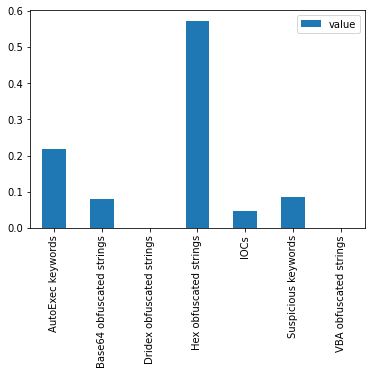

In [41]:
f_i=pd.DataFrame(model.feature_importances_,index=x_train.columns,columns=['value'])
f_i.plot(kind='bar')



In [42]:
print("Правильность на тестовом наборе: {:.2f}".format(model.score(x_test,y_test)))


Правильность на тестовом наборе: 0.89


In [43]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [44]:
scaler.fit(x_train)
x_train_sc=scaler.transform(x_train)
x_test_sc=scaler.transform(x_test)

In [45]:
model_svm=SVC(C=2000).fit(x_train_sc,y_train)

In [46]:
models.update({"SVC(C=2000)":[model_svm,scaler]})

In [47]:
print("Правильность на тестовом наборе: {:.2f}".format(model_svm.score(x_test_sc, y_test)))

Правильность на тестовом наборе: 0.86


In [48]:
from sklearn.neural_network import MLPClassifier

mpl=MLPClassifier(solver='lbfgs',activation='tanh',max_iter=10000,random_state=0,hidden_layer_sizes=[20])
mpl.fit(x_train_sc,y_train)


MLPClassifier(activation='tanh', hidden_layer_sizes=[20], max_iter=10000,
              random_state=0, solver='lbfgs')

In [49]:
models.update({"MLPClassifier(solver='lbfgs',activation='tanh',max_iter=10000,random_state=0,hidden_layer_sizes=[20])"
               :[mpl,scaler]})

In [50]:
mpl.score(x_train_sc,y_train)

0.7813078346699568

In [51]:
mpl.score(x_test_sc,y_test)

0.7849213691026827

In [52]:
from sklearn.neural_network import MLPClassifier

mpl=MLPClassifier(solver='adam',activation='relu',max_iter=10000,random_state=5,hidden_layer_sizes=[100,10])
mpl.fit(x_train_sc,y_train)

MLPClassifier(hidden_layer_sizes=[100, 10], max_iter=10000, random_state=5)

In [53]:
models.update({"MLPClassifier(solver='adam',activation='relu',max_iter=10000,random_state=5,hidden_layer_sizes=[100,10])"
               :[mpl,scaler]})

In [54]:
mpl.score(x_train_sc,y_train)

0.8821714990746453

In [55]:
mpl.score(x_test_sc,y_test)

0.8714153561517114

In [56]:
models.keys()

dict_keys(["LogisticRegression(solver='newton-cg',C=0.5)", "LogisticRegression(solver='newton-cg',C=0.5) with TFIDF", 'RandomForestClassifier(random_state=100,max_features=5,max_depth=10,n_estimators=50)', 'SVC(C=2000)', "MLPClassifier(solver='lbfgs',activation='tanh',max_iter=10000,random_state=0,hidden_layer_sizes=[20])", "MLPClassifier(solver='adam',activation='relu',max_iter=10000,random_state=5,hidden_layer_sizes=[100,10])"])

In [57]:
test_file='/home/v-osipov/test.bas'

In [58]:
def _test_(file,models):
    from to_test import for_bag_word,from_oletools
    
    test_for_bag,test_for_num_model=for_bag_word(test_file,0),from_oletools(test_file,0)
    for model in models:
        try:
            if isinstance(models[model][1],CountVectorizer):
            
                test=models[model][1].transform(test_for_bag['text'])
                prd=models[model][0].predict(test)
                print('модель:',model,'\n')
                print(f"Истинное значение {test_for_bag['virus'].values} Предсказанное {prd}",'\n','_'*39,'\n')
            
            else:
                
                test=models[model][1].transform(test_for_num_model[[x for x in data_num.columns if x!='virus']])
                prd=models[model][0].predict(test)
                print('модель:',model,'\n')
                print(f"Истинное значение {test_for_num_model['virus'].values} Предсказанное {prd}",'\n','_'*39,'\n')

        except IndexError:
            prd=models[model][0].predict(test_for_num_model[[x for x in data_num.columns if x!='virus']])
            print('модель:',model,'\n')
            print(f"Истинное значение{test_for_num_model['virus'].values} Предсказанное {prd}",'\n','_'*39,'\n')
        except ValueError:
            print(model,'не сработала!\n')


In [59]:
_test_(test_file,models)

ImportError: cannot import name 'from_oletools' from 'to_test' (/home/v-osipov/PycharmProjects/vba/vba/to_test.py)

In [ ]:
models

In [ ]:
for model in models:
    try:
        if isinstance(models[model][1],CountVectorizer):
            
                test=models[model][1].transform(test_for_bag['text'])
                prd=models[model][0].predict(test)
                print('модель:',model,'\n')
                print(f"Истинное значение {test_for_bag['virus'].values} Предсказанное {prd}",'\n','_'*39,'\n')
        else:
            
            test=models[model][1].transform(test_for_num_model[[x for x in data_num.columns if x!='virus']])
            prd=models[model][0].predict(test)
            print('модель:',model,'\n')
            print(f"Истинное значение {test_for_num_model['virus'].values} Предсказанное {prd}",'\n','_'*39,'\n')
            
    except IndexError:
        
            prd=models[model][0].predict(test_for_num_model[[x for x in data_num.columns if x!='virus']])
            print('модель:',model,'\n')
            print(f"Истинное значение {test_for_num_model['virus'].values} Предсказанное {prd}",'\n','_'*39,'\n')
    except ValueError:
            print(model,'не сработала!\n')
            
            